## Week 02 - Duke Tickets Example

This example loads the Duke Tickets A data example and performs regression in Python. 

Author: Chris Kennedy


#### To Do (Future Versions):
Use machine-learning pipeline functionality for training to illustrate a production process

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import metrics
import datetime

### Prepare the Data

In [2]:
dfDuke = pd.read_excel(r'W2 - DukeTixA.xlsx')

In [3]:
dfDuke.head(5)

,Observation,Price,Date,Quantity,Row,Deck,UNC rank,Duke rank
0,1,1400,2011-11-01,2,t,L,1,6
1,2,665,2011-11-01,4,g,U,1,6
2,3,565,2011-11-03,2,w,U,1,6
3,4,590,2011-11-03,2,q,U,1,6
4,5,750,2011-11-06,2,o,U,1,6


In [4]:
dfDuke.describe()

,Observation,Price,Quantity,UNC rank,Duke rank
count,203.000000,203.000000,203.000000,203.000000,203.000000
mean,102.000000,649.492611,2.275862,4.753695,7.546798
std,58.745213,557.724509,0.753052,1.658588,1.760830
min,1.000000,55.000000,1.000000,1.000000,3.000000
25%,51.500000,300.000000,2.000000,5.000000,7.000000
50%,102.000000,495.000000,2.000000,5.000000,7.000000
75%,152.500000,750.000000,2.000000,5.000000,9.000000
max,203.000000,4785.000000,4.000000,8.000000,10.000000


Check for missing/null values

In [5]:
dfDuke.isnull().sum()

Observation    0
Price          0
Date           0
Quantity       0
Row            0
Deck           0
UNC rank       0
Duke rank      0
dtype: int64

Check datatypes for regression

In [6]:
dfDuke.dtypes

Observation             int64
Price                   int64
Date           datetime64[ns]
Quantity                int64
Row                    object
Deck                   object
UNC rank                int64
Duke rank               int64
dtype: object

#### Clean Data
1. Fix Dates
2. One-Hot-Encode the Quantity
3. Apply lambda to "Row"
4. One-Hot-Encode "Deck"
5. Prepare Calculated Fields from UNC and Duke Rank

In [7]:
# 1. Fix Dates
game_day = dfDuke['Date'].max()
dfDuke['Days to Game'] = (game_day - dfDuke['Date']) / datetime.timedelta(days=1)


In [8]:
# 2. One-Hot Encode the Quantity
dfQ = pd.get_dummies(dfDuke['Quantity'], drop_first=True, prefix='Quantity')
dfDuke = dfDuke.join(dfQ)

In [9]:
# 3. Apply Lambda to "Row"
dfDuke['Row (Clean)'] = dfDuke['Row'].str.strip()
dfDuke['Row Number'] = dfDuke['Row (Clean)'].apply ( \
        lambda x: ord(x) - 96 if len(x) == 1 else ord(x[0]) - 96)

In [10]:
# 4. One-Hot Encode Deck
dfDuke['Upper Deck'] = pd.get_dummies(dfDuke['Deck'], drop_first=True)

In [11]:
#5. Prepare calculated fields from UNC and Duke Rank
dfDuke['RankSum'] = dfDuke['UNC rank'] + dfDuke['Duke rank']
dfDuke['RankDif'] = abs(dfDuke['UNC rank'] - dfDuke['Duke rank'])

Drop extra columns and split the data into X and y:

In [12]:
y = dfDuke['Price']
X = dfDuke.drop(columns=['Price','Observation','Row','Row (Clean)', 'Date', 'Deck', 'UNC rank', 'Duke rank', 'Quantity'])

In [13]:
# Check our X data frame
X.head()

,Days to Game,Quantity_2,Quantity_3,Quantity_4,Row Number,Upper Deck,RankSum,RankDif
0,99.0,1,0,0,20,0,7,5
1,99.0,0,0,1,7,1,7,5
2,97.0,1,0,0,23,1,7,5
3,97.0,1,0,0,17,1,7,5
4,94.0,1,0,0,15,1,7,5


### Prepare the Regressions

#### Specify Hyperparameters 
Normally we would calibrate the regularization parameter using a grid-search or cross-validation; however, for simplicity we are just using $\lambda$ = 10.0.


In [14]:
regLambda = 10.0 # Note that lambda is a protected word in python

Given hyperparameters, initialize the models - no hyperparameters for classical linear regression.

In [15]:
classicLR = LinearRegression()
ridgeLR = Ridge(alpha = regLambda)

#### Fit the models

In [16]:
model_CLR = classicLR.fit(X, y)

In [17]:
model_RLR = ridgeLR.fit(X, y)

#### Build predictions (in-sample)

In [18]:
yp = model_CLR.predict(X)
ypr = model_RLR.predict(X)

#### Simple performance metrics
We are not using a validation/holdout set this week. Typically cross-validation or train/validate/test splits would apply when evaluating machine learning models.

In [19]:
print("Classical: ")
print("R2:   %10.3f" % metrics.r2_score(y, yp))
print("RMSE: %10.4f" % metrics.mean_squared_error(y, yp) ** 0.5)
print("")
print("Ridge:")
print("R2:   %10.3f" % metrics.r2_score(y, ypr))
print("RMSE: %10.4f" % metrics.mean_squared_error(y, ypr) ** 0.5)

Classical: 
R2:        0.429
RMSE:   420.2544

Ridge:
R2:        0.418
RMSE:   424.4176


#### Output intercepts and coefficients for comparison

In [20]:
#  Simple vs. Regularized (Ridge)
cols= len(X.columns)
coeffs = [model_CLR.coef_, model_RLR.coef_]

print ("%14s" % "VAR", "%11s" % "SIMPLE", "%11s" % "RIDGE", "%11s" % "Delta")
print ("%14s" % "Intecept", "%11.4f" % model_CLR.intercept_, "%11.4f" % model_RLR.intercept_, "%11.4f" % (model_CLR.intercept_ - model_RLR.intercept_))    
for i in range(0,cols):
    print("%14s" % X.columns[i], "%11.4f" % coeffs[0][i], "%11.4f" % coeffs[1][i], "%11.4f" % (coeffs[0][i] - coeffs[1][i]))


           VAR      SIMPLE       RIDGE       Delta
      Intecept   1250.7322   1268.4101    -17.6779
  Days to Game      5.9223      5.6874      0.2350
    Quantity_2    109.4939     58.3309     51.1630
    Quantity_3   -165.9811    -56.6931   -109.2879
    Quantity_4     40.9764     -2.2518     43.2282
    Row Number    -15.8415    -15.9277      0.0862
    Upper Deck   -641.0195   -521.1882   -119.8313
       RankSum     -1.2886     -3.9505      2.6619
       RankDif    -62.5887    -64.7643      2.1756


### Plots and visualizations

In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Plot Y vs. Prediction using Classical and Ridge

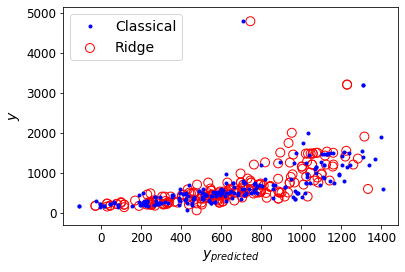

In [22]:
plt.plot(yp, y, "b.", label="Classical")
plt.scatter(ypr, y, s=80, facecolors='none', edgecolors='r', label="Ridge")
plt.xlabel("$y_{predicted}$")
plt.ylabel("$y$")
plt.legend(loc="upper left", fontsize=14)
plt.show()

Plot residuals for classical and ridge

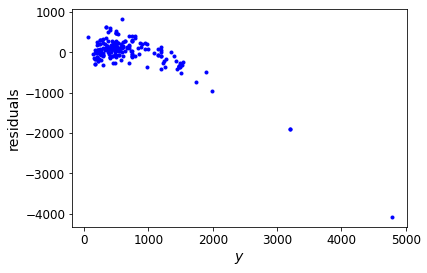

In [23]:
plt.plot(y, (yp - y), "b.")
plt.xlabel("$y$")
plt.ylabel("residuals")
plt.show()

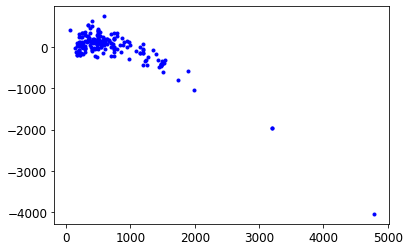

In [24]:
plt.plot(y,(ypr-y), "b.")
plt.show()

### End of Notebook!